In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import pickle 
import os
import sys
import pandas as pd
from scipy.ndimage import rotate, gaussian_filter
import pickle 
from scipy.stats import circmean, circstd, sem

sys.path.append('../defect_functions') 
from defect_pairs import * 
from average_flows import * 

save_folder = r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images"

image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

### Test flow parameters
`flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)`

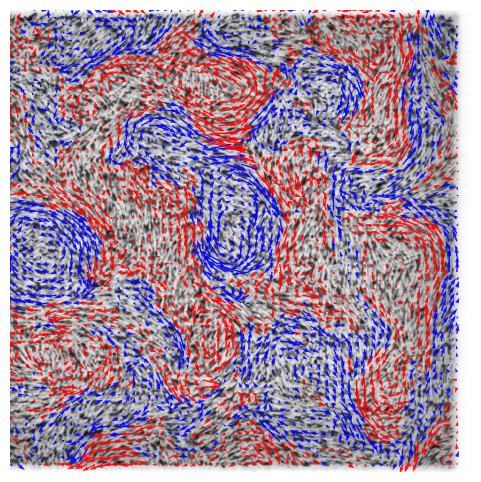

In [2]:
%matplotlib inline
SAVE = True

im_num = 100

img1 = cv2.imread(image_list[im_num])[:,900:,0]
img2 = cv2.imread(image_list[im_num+1])[:,900:,0]
flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
    winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(6,6))
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax1.axis('off')    
# ax1.imshow(img1, cmap="gray")
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)
ax1.imshow(255-img_clahe, cmap="gray")  

if SAVE:
    fig.savefig(save_folder + "/raw.svg", bbox_inches=extent.expanded(1.15, 1.15))                                     

field = np.stack((flow[:,:,0], flow[:,:,1]), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=15)
# c = ax1.imshow(vorticity, cmap='RdBu', alpha=.3)
# fig.colorbar(c, ax=ax1)

vort_min = 0.005
vortTFr = vorticity > vort_min
vortTFl = vorticity < vort_min
ur = flow[:,:,0] * vortTFr
vr = flow[:,:,1] * vortTFr
ul = flow[:,:,0] * vortTFl
vl = flow[:,:,1] * vortTFl

y, x = np.mgrid[0:img1.shape[0], 0:img1.shape[1]]
# ax1.quiver(x[::step, ::step], y[::step, ::step], 
#         flow[::step, ::step, 0], -flow[::step, ::step, 1], 
#         color="red", scale=120, alpha=.9, width=.003)

ax1.quiver(x[::step, ::step], y[::step, ::step], 
        ur[::step, ::step], -vr[::step, ::step], 
        color="b", scale=120, alpha=.9, width=.003, minlength=0)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
        ul[::step, ::step], -vl[::step, ::step], 
        color="r", scale=120, alpha=.9, width=.003, minlength=0)           
        

# speed = np.sqrt(flow[:,:,0]**2 + flow[:,:,0]**2)
# lw = 3*speed / speed.max()
# ax1.streamplot(x[::step, ::step],y[::step, ::step],
#         flow[::step, ::step, 0], flow[::step, ::step, 1], 
#         density=4., color='white', linewidth=lw[::step, ::step])

if SAVE:
    fig.savefig(save_folder + "/flow_field.svg", bbox_inches=extent.expanded(1.15, 1.15))



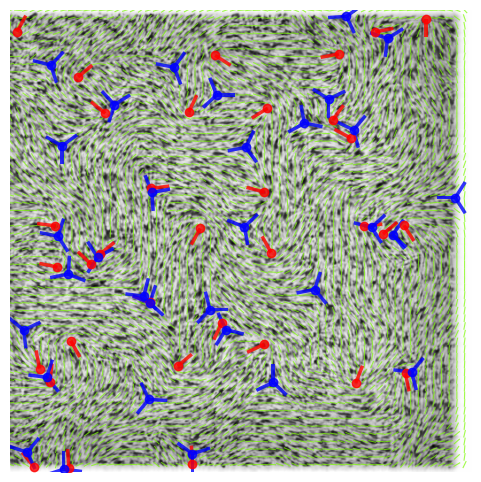

In [3]:
%matplotlib inline

ori, plushalf, minushalf = analyze_defects(img1, sigma=11)

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(6,6))
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax1.axis('off')   

ax1.imshow(255-img_clahe, cmap="gray")

s = 15
# x = np.arange(0, img1.shape[1], s)
# y = np.arange(0, img1.shape[0], s)
y, x = np.mgrid[0:img1.shape[0], 0:img1.shape[1]]

ax1.quiver(x[::s,::s], y[::s,::s],
    np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
    headaxislength=0, headwidth=0, headlength=0, 
    color='lawngreen', scale=60, pivot='mid', alpha=.7)

alpha_half, scale_half = .8, 25    
ax1.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=alpha_half)
ax1.quiver(plushalf['x'], plushalf['y'], 
    np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

ax1.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=alpha_half)
for j in range(3):
    ax1.quiver(minushalf['x'], minushalf['y'], 
        np.cos(minushalf['ang'+str(j+1)]), -np.sin(minushalf['ang'+str(j+1)]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        
if SAVE:
    fig.savefig(save_folder + "/director_field1.svg", bbox_inches=extent.expanded(1.15, 1.15))


In [11]:
image_list = glob.glob(r"C:\Users\victo\Downloads\SB_lab\BEER_DATA\ISF defects new\6\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

In [14]:
num = 100
vel_ori_list = []
for (im_num,img1),img2 in zip(enumerate(image_list[:num]),image_list[1:num+1]):
    imgR1 = cv2.imread(img1)[:,:900,0]
    imgR2 = cv2.imread(img2)[:,:900,0]
    flowR = cv2.calcOpticalFlowFarneback(imgR1,imgR2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 
    flowR_ang = np.arctan2(flowR[:,:,1],flowR[:,:,0])
    

    imgL1 = cv2.imread(img1)[:,900:,0]    
    imgL2 = cv2.imread(img2)[:,900:,0]    
    flowL = cv2.calcOpticalFlowFarneback(imgL1,imgL2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 
    flowL_ang = np.arctan2(flowL[:,:,1],flowL[:,:,0])

    # sigma = 11
    # oriR,_,_ = analyze_defects(imgR, sigma=sigma)
    # oriL,_,_ = analyze_defects(imgL, sigma=sigma)
    # d_ori = ((oriR-oriL).ravel()%(np.pi)) *180/np.pi

    d_ori = ((flowR_ang-flowL_ang).ravel()%(np.pi)) *180/np.pi
    d_ori[d_ori>90] = d_ori[d_ori>90] - 180
    vel_ori_list.append(d_ori)
    # p = plt.hist(d_ori, 60, alpha=.1)
    # break
    progressBar(im_num, num)

Text(0.5, 1.0, '$Angle ~difference ~btw ~velocity ~fields$')

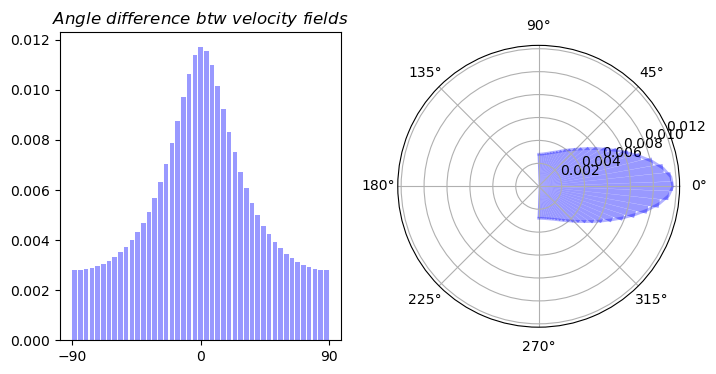

In [17]:
%matplotlib inline
bins_number = 45  # the [0, 360) interval will be subdivided into this
bins = np.linspace(-np.pi/2, np.pi/2, bins_number+1) #* 180/np.pi
bins_ = np.linspace(-np.pi/2, np.pi/2, bins_number)
width = 2 * np.pi / bins_number

data = np.concatenate(vel_ori_list)

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p2,_,_ = ax1.hist(data, bins*180/np.pi, alpha=.4, density=True, rwidth=.8, color="b")
ax1.set_xticks([-90,0,90])
ax2.bar(bins_, p2, color="b", width=width/2, bottom=0., alpha=.4)
# ax2.set_rgrids(np.arange(0,.025,.005), angle=135); ax2.set_thetagrids([0,90,180,270])

ax2.plot(bins_, p2, "b", linewidth=2, alpha=.3)
# ax2.fill_between(bins_, p2, color="b", alpha=.2)

ax1.set_title(r"$Angle ~difference ~btw ~velocity ~fields$")

In [18]:
num = 100
d_ori_list = []
for im_num,img in enumerate(image_list[:num]):
    imgR = cv2.imread(img)[:,:900,0]
    imgL = cv2.imread(img)[:,900:,0]

    sigma = 11
    oriR,_,_ = analyze_defects(imgR, sigma=sigma)
    oriL,_,_ = analyze_defects(imgL, sigma=sigma)
    d_ori = ((oriR-oriL).ravel()%(np.pi)) *180/np.pi
    d_ori[d_ori>90] = d_ori[d_ori>90] - 180
    d_ori_list.append(d_ori)
    # p = plt.hist(d_ori, 60, alpha=.1)
    # break
    progressBar(im_num, len(image_list[:100]))

Text(0.5, 1.0, '$Angle ~difference ~btw ~director ~fields$')

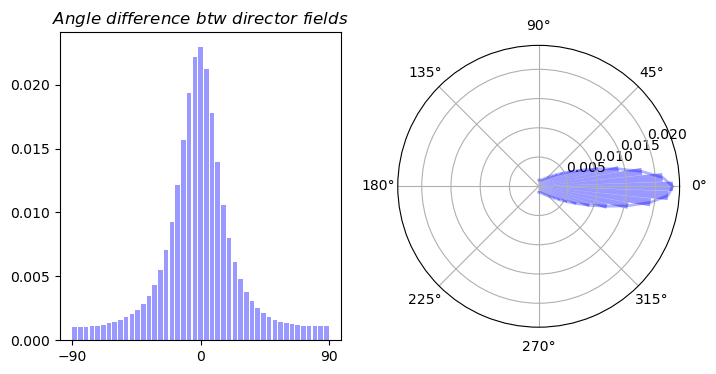

In [5]:
%matplotlib inline
bins_number = 45  # the [0, 360) interval will be subdivided into this
bins = np.linspace(-np.pi/2, np.pi/2, bins_number+1) #* 180/np.pi
bins_ = np.linspace(-np.pi/2, np.pi/2, bins_number)
width = 2 * np.pi / bins_number

data = np.concatenate(d_ori_list)

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p2,_,_ = ax1.hist(data, bins*180/np.pi, alpha=.4, density=True, rwidth=.8, color="b")
ax1.set_xticks([-90,0,90])
ax2.bar(bins_, p2, color="b", width=width/2, bottom=0., alpha=.4)
# ax2.set_rgrids(np.arange(0,.025,.005), angle=135); ax2.set_thetagrids([0,90,180,270])

ax2.plot(bins_, p2, "b", linewidth=2, alpha=.3)
# ax2.fill_between(bins_, p2, color="b", alpha=.2)

ax1.set_title(r"$Angle ~difference ~btw ~director ~fields$")


In [6]:
%matplotlib qt

fig, ax1 = plt.subplots(1,1,  figsize=(8,8))
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
  
pairs = []
for im_num,img in enumerate(image_list[32:]):
    ax1.clear(); ax1.axis('off') 
    # im_num = 160

    imgR = cv2.imread(img)[:,:900,0]
    imgL = cv2.imread(img)[:,900:,0]

    # step = 15


    sigma = 11
    oriR, plusR, minR = analyze_defects(imgR, sigma=sigma)
    oriL, plusL, minL = analyze_defects(imgL, sigma=sigma)

    dist, idx = center_pairs(plusR[["x","y"]], plusL[["x","y"]])
    # set a distance that define that defects are a pair (50)
    # dist_tresh = dist<20
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory

    # print(plusR[["x","y","ang1"]].iloc[idx][dist_tresh][:3])#.astype(np.int_), 
    # print(plusL[["x","y","ang1"]][dist_tresh][:3]),#.astype(np.intc)
    # print(dist[dist_tresh][:3])

    pairs.append(pd.DataFrame({
            "FRAME": im_num * np.ones((len(idx))),
            "xpR": plusR["x"].iloc[idx].values,
            "ypR": plusR["y"].iloc[idx].values, 
            "angpR": plusR["ang1"].iloc[idx].values,
            "xpL": plusL["x"].values,
            "ypL": plusL["y"].values, 
            "angpL": plusL["ang1"].values,
            "distanace": dist
            }))
    progressBar(im_num,len(image_list))    

    # if not im_num%50:
    #     pairsRL_df = pd.concat(pairs)
    #     pairsRL_df.to_csv(save_folder + "/LR_plus_defects_6.csv")

    # plot_orientation_analysis(imgR, oriR, plusR, minR, ax=ax1, colors=[False,"r", "r"], alpha=.3, imshow=False)
    # plot_orientation_analysis(imgL, oriL, plusL, minL, ax=ax1, colors=[False,"g", "g"], alpha=.3, imshow=False)

    dist_tresh = dist<35
    plot_orientation_analysis(imgR, oriR, plusR[["x","y","ang1"]].iloc[idx][dist_tresh], minR, ax=ax1, colors=["r",False,False])
    plot_orientation_analysis(imgL, oriL, plusL[["x","y","ang1"]][dist_tresh], minL, ax=ax1, colors=["g",False,False])
    # fig.savefig(save_folder+"/3D-1/"+str(im_num)+".png", bbox_inches=extent.expanded(1.05, 1.05))
    break

pairsRL_df = pd.concat(pairs)
# pairsRL_df.to_csv(save_folder + "/LR_plus_defects_6.csv")

In [7]:
pairsRL_df = pd.read_csv(save_folder + "/LR_plus_defects_6.csv")
pairsRL_df["dang"] = (pairsRL_df.angpL - pairsRL_df.angpR) % (2*np.pi)
pairsRL_df["ang_pos_shift"] = np.arctan2(pairsRL_df.ypL-pairsRL_df.ypR, 
                                         pairsRL_df.xpL-pairsRL_df.xpR) - pairsRL_df.angpR

Text(0.5, 1.0, '$Angle ~difference ~btw ~+1/2 ~defects ~at ~layers$')

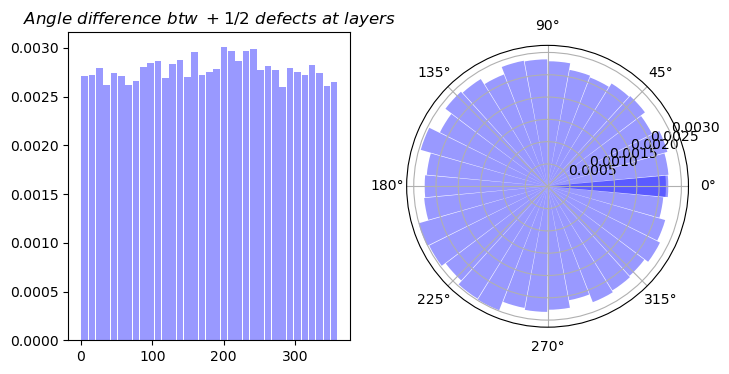

In [8]:
%matplotlib inline
bins_number = 35  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
bins_ = np.linspace(0, 2*np.pi, bins_number)
width = 2 * np.pi / bins_number

df_p = pairsRL_df["ang_pos_shift"][pairsRL_df.distanace<35]%(2*np.pi)#
# df_p[df_p>np.pi] = df_p[df_p>np.pi] - 2*np.pi

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p2,_,_ = ax1.hist(df_p*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
ax2.bar(bins_, p2, color="b", width=width, bottom=0., alpha=.4)
# ax2.set_rgrids(np.arange(0,.015,.003), angle=90); ax2.set_thetagrids([0,45,90,180,270,315])

# ax2.plot(bins_, p2, "b", linewidth=2, alpha=.6)
# ax2.fill_between(bins_, p2, color="b", alpha=.2)

ax1.set_title(r"$Angle ~difference ~btw ~+1/2 ~defects ~at ~layers$")

(0.0, 100.0)

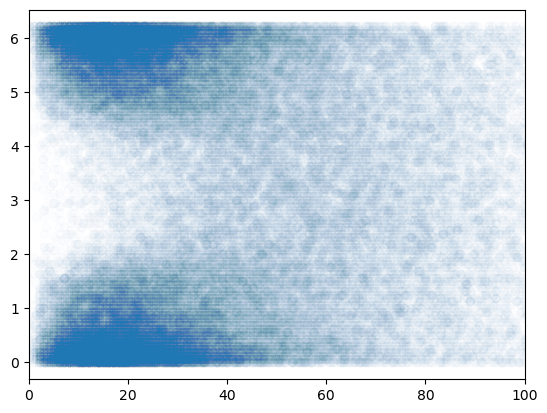

In [9]:
plt.plot(pairsRL_df.distanace, pairsRL_df.dang.abs(), "o", alpha=.01)
plt.xlim([0,100])

Text(0, 0.5, '$Count$')

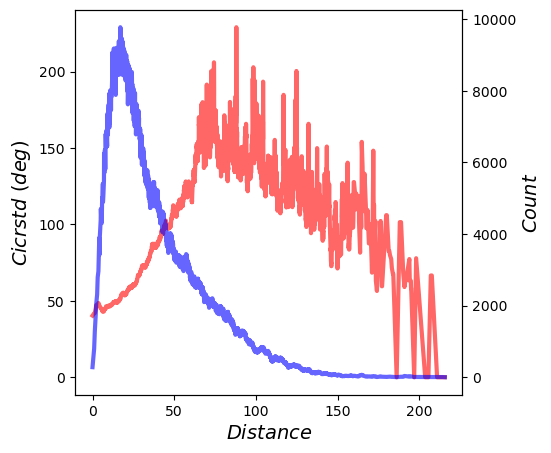

In [10]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
df = plot_rolling_average(pairsRL_df, ax1, "dang", "distanace", show=False, win=1, color="r", low=-np.pi, high=np.pi)
ax1.plot(df.distanace, df.dang_std, "-", color="r", alpha=.6, linewidth=3)
ax2 = ax1.twinx()
ax2.plot(df.distanace, df.dang_count, "-", color="b", alpha=.6, linewidth=3)
ax1.set_xlabel("$Distance$", fontsize=14)
ax1.set_ylabel("$Cicrstd ~(deg)$", fontsize=14)
ax2.set_ylabel("$Count$", fontsize=14)

(0.0, 120.0)

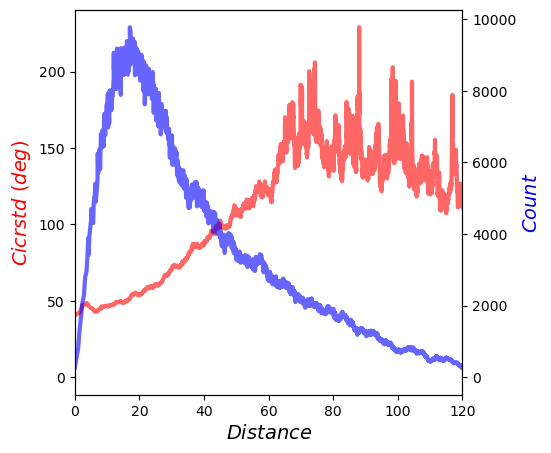

In [11]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
ax1.plot(df.distanace, df.dang_std, "-", color="r", alpha=.6, linewidth=3)
ax2 = ax1.twinx()
ax2.plot(df.distanace, df.dang_count, "-", color="b", alpha=.6, linewidth=3)
ax1.set_xlabel("$Distance$", fontsize=14)
ax1.set_ylabel("$Cicrstd ~(deg)$", fontsize=14, color='r')
ax2.set_ylabel("$Count$", fontsize=14, color='b')
plt.xlim([0,120])

<AxesSubplot: >

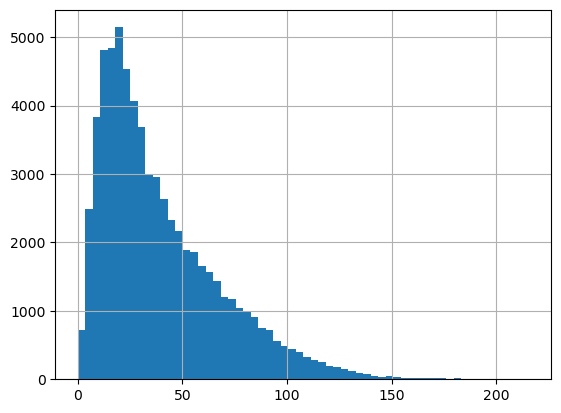

In [12]:
pairsRL_df.distanace.hist(bins=60)

Text(0.5, 1.0, '$Angle ~difference ~btw ~+1/2 ~defects ~at ~layers$')

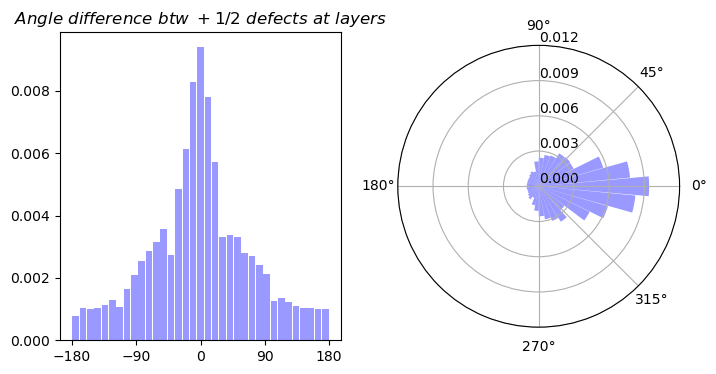

In [13]:
%matplotlib inline
bins_number = 35  # the [0, 360) interval will be subdivided into this
bins = np.linspace(-np.pi, np.pi, bins_number+1) #* 180/np.pi
bins_ = np.linspace(-np.pi, np.pi, bins_number)
width = 2 * np.pi / bins_number

df_p = pairsRL_df["dang"][pairsRL_df.distanace<70]
df_p[df_p>np.pi] = df_p[df_p>np.pi] - 2*np.pi

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p2,_,_ = ax1.hist(df_p*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
ax1.set_xticks([-180,-90,0,90,180])
ax2.bar(bins_, p2, color="b", width=width, bottom=0., alpha=.4)
ax2.set_rgrids(np.arange(0,.015,.003), angle=90); ax2.set_thetagrids([0,45,90,180,270,315])

# ax2.plot(bins_, p2, "b", linewidth=2, alpha=.6)
# ax2.fill_between(bins_, p2, color="b", alpha=.2)

ax1.set_title(r"$Angle ~difference ~btw ~+1/2 ~defects ~at ~layers$")

In [14]:
from scipy.stats import circmean, circstd, sem
circmean(pairsRL_df["dang"], low=-np.pi, high=np.pi), circstd(pairsRL_df["dang"], low=-np.pi, high=np.pi)

(-0.037758081745824956, 1.3618281066883189)

In [15]:
stop_error

NameError: name 'stop_error' is not defined

In [ ]:
u = []
v = []

for (i,im1), im2 in zip(enumerate(image_list[:-1]), image_list[1:]):
    #right image [:,900:,0] / left image [:,:900,0]
    img1 = cv2.imread(im1)[:,900:,0]
    img2 = cv2.imread(im2)[:,900:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    u.append(flow[..., 0])
    v.append(flow[..., 1])

    # if i>10:
    #     break

    progressBar(i, len(image_list))

# with open(save_folder + "/flow.pkl", 'wb') as f:
#     pickle.dump(dict(u=u, v=v), f)

In [ ]:
energy_list = [((uu**2+vv**2)/2.) for (uu,vv) in zip(u,v)]
energy_av_std = np.array([(np.mean(e), np.std(e)) for e in energy_list])

(0.0, 5.0)

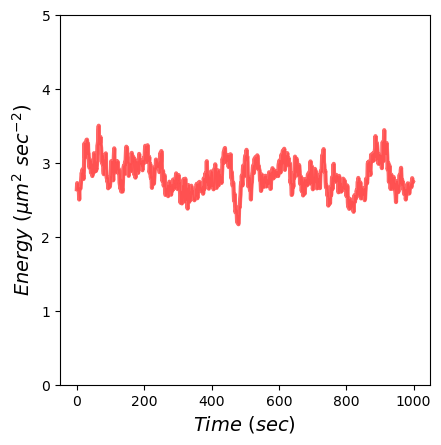

In [ ]:
plt.plot(np.arange(len(energy_av_std[:,0])), energy_av_std[:,0], "r", linewidth=3, alpha=.6)
plt.fill_between(np.arange(len(energy_av_std)),
    energy_av_std[:,0] - energy_av_std[:,1]/900, energy_av_std[:,0] + energy_av_std[:,1]/900,
    color="r", alpha=.2)  
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Energy ~(\mu m^2 ~sec^{-2})$", fontsize=14)
plt.gca().set_box_aspect(1)
plt.ylim([0,5])
 

In [ ]:
enstrophy_list = [(np.gradient(vv)[1] - np.gradient(uu)[0])**2/2. for (uu,vv) in zip(u,v)]
enstropy_av_std = np.array([(np.mean(e), np.std(e)) for e in enstrophy_list])

# [u_x,u_y] = np.gradient(px_size * uf,dx);
# %         [v_x,v_y] = gradient(px_size * vf,dx);
# %         enstrophy(k,i) = mean2(0.5*(v_x - u_y).^2);

(0.0, 0.02)

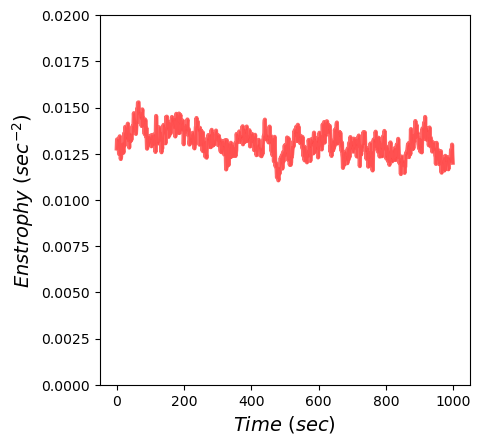

In [ ]:
plt.plot(np.arange(len(enstropy_av_std[:,0])), enstropy_av_std[:,0], "r", linewidth=3, alpha=.6)
plt.fill_between(np.arange(len(enstropy_av_std)),
    enstropy_av_std[:,0] - enstropy_av_std[:,1]/900, enstropy_av_std[:,0] + enstropy_av_std[:,1]/900,
    color="r", alpha=.2)   
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Enstrophy ~(sec^{-2})$", fontsize=14)       
plt.gca().set_box_aspect(1)
plt.ylim([0,.02])

(0.0, 0.02)

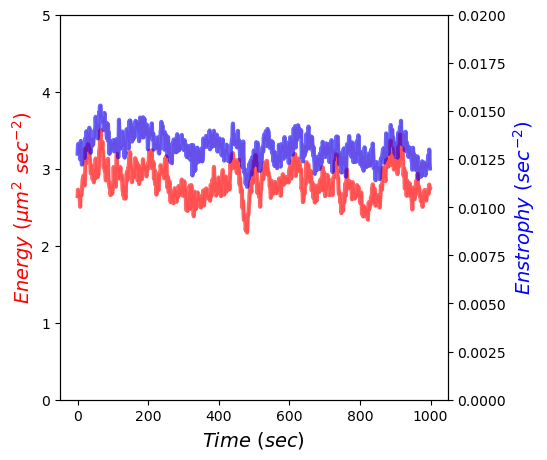

In [ ]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
ax1.plot(np.arange(len(energy_av_std[:,0])), energy_av_std[:,0], "r", linewidth=3, alpha=.6)
ax1.fill_between(np.arange(len(energy_av_std)),
    energy_av_std[:,0] - energy_av_std[:,1]/900, energy_av_std[:,0] + energy_av_std[:,1]/900,
    color="r", alpha=.2)  
ax1.set_xlabel(r"$Time ~(sec)$", fontsize=14)
ax1.set_ylabel(r"$Energy ~(\mu m^2 ~sec^{-2})$", fontsize=14, color='r')

ax1.set_ylim([0,5])
ax2 = ax1.twinx()
ax2.plot(np.arange(len(enstropy_av_std[:,0])), enstropy_av_std[:,0], "b", linewidth=3, alpha=.6)
ax2.fill_between(np.arange(len(enstropy_av_std)),
    enstropy_av_std[:,0] - enstropy_av_std[:,1]/900, enstropy_av_std[:,0] + enstropy_av_std[:,1]/900,
    color="r", alpha=.2)   
ax2.set_ylabel(r"$Enstrophy ~(sec^{-2})$", fontsize=14, color='b')       
ax2.set_ylim([0,.02])

Text(0, 0.5, '$Enstrophy ~(sec^{-2})$')

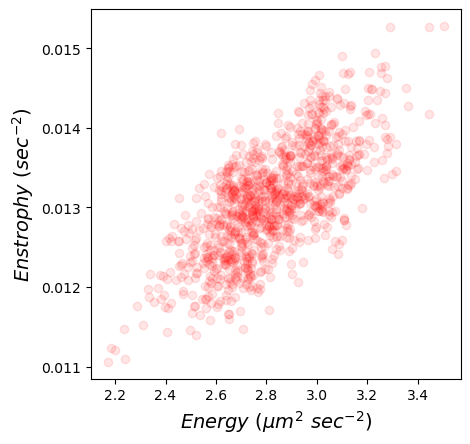

In [ ]:
%matplotlib inline
plt.plot(energy_av_std[:,0], enstropy_av_std[:,0], "or", alpha=.1)
plt.gca().set_box_aspect(1)
plt.xlabel(r"$Energy ~(\mu m^2 ~sec^{-2})$", fontsize=14)
plt.ylabel(r"$Enstrophy ~(sec^{-2})$", fontsize=14)

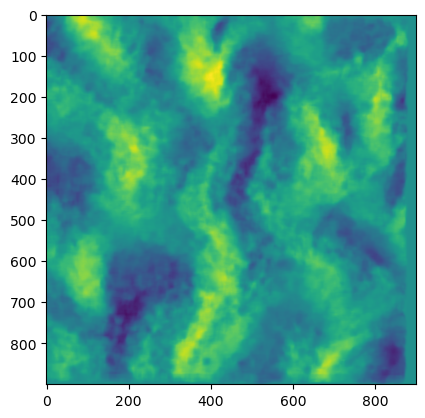

In [ ]:
plt.imshow(np.mean(v, axis=0))

# Start Here Find Pairs

In [3]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd, sem
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random

sys.path.append('../defect_functions') 
from defect_pairs import * 
from average_flows import * 

plus_minus_df = pd.read_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects/PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID278212,278212,0.0,81.421532,552.0,478.0,0.0,0.0,0,...,0.973672,1.625018,733.764838,268.454037,734.0,269.0,0.942478,NaN,NaN,0.5
1,1,ID278213,278213,1.0,81.421532,531.0,508.0,0.0,0.0,0,...,0.973672,1.625018,703.283614,224.629008,703.0,225.0,0.314159,NaN,NaN,0.5
2,2,ID278214,278214,2.0,81.421524,185.0,517.0,0.0,0.0,0,...,0.973672,1.625018,201.069153,211.481499,201.0,212.0,-1.005310,NaN,NaN,0.5
3,3,ID278215,278215,3.0,81.421524,274.0,524.0,0.0,0.0,0,...,0.973672,1.625018,330.251486,201.255659,330.0,202.0,-1.507964,NaN,NaN,0.5
4,4,ID278208,278208,NaN,68.126724,90.0,380.0,0.0,0.0,0,...,0.923249,1.053494,63.177900,411.615798,62.0,411.0,1.696460,NaN,NaN,0.5


In [4]:
charge_p = []
charge_n = []
for frame in plus_minus_df.FRAME.unique():
    charge_p.append(plus_minus_df.charge[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())
    charge_n.append(plus_minus_df.charge[~(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())

charge_p = np.array(charge_p)
charge_n = np.array(charge_n)
plt.plot(plus_minus_df.FRAME.unique(), 2*charge_p, "-r", alpha=.5, label=r"+1/2")
plt.plot(plus_minus_df.FRAME.unique(), 2*np.abs(charge_n), "-b", alpha=.5, label=r"-1/2")

plt.ylim([0,60])
# plt.title(r"$Absolute ~Charge ~of ~\pm 1/2 ~defects$", fontsize=14)
plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Number ~of ~defects ~(sec)$", fontsize=14)
plt.legend()
plt.gca().set_box_aspect(1)
        

(100.0, 100000.0)

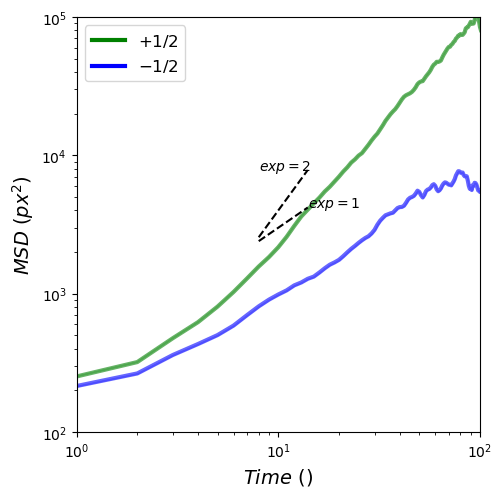

In [5]:
msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"x_img1","x_img1","FRAME","TRACK_ID")
msd_minus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==-.5],"x_img1","x_img1","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(8, 15, 1)
ax2.plot(xref, 4e1*xref**2, "--k", xref, 3e2*xref**1, "--k",)
ax2.text(xref[0], 4e1*xref[-1]**2, r"$exp=2$", )
ax2.text(xref[-1], 3e2*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()
plt.xlim([1,100]);plt.ylim([1e2,1e5])

(0.01, 100.0)

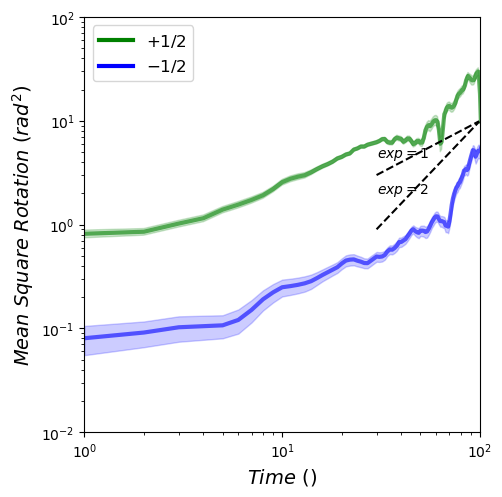

In [29]:
# plus_minus_df["angm_ave"] = circmean(plus_minus_df[["ang1","ang2","ang2"]], high=2/3*np.pi, axis=1)
plus_minus_df["angm_ave"] = plus_minus_df["ang1"] % (2/3*np.pi)
plus_minus_df1 = plus_minus_df[["ang1","angm_ave","charge","FRAME","TRACK_ID"]]

msd_plus_df = ang_msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME>10)],
                              "ang1","FRAME","TRACK_ID", minimal_track=20)
msd_minus_df = ang_msd_from_df(plus_minus_df1[(plus_minus_df1.charge==-.5)&(plus_minus_df.FRAME>10)],
                               "angm_ave","FRAME","TRACK_ID",period=2/3*np.pi, minimal_track=20)


# msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"ang1","ang1","FRAME","TRACK_ID",minimal_track=10)
# msd_minus_df = msd_from_df(plus_minus_df1[plus_minus_df1.charge==-.5],"angm_ave","angm_ave","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1
 
for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 
    # TODO check the "count" 
    # break


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(30, 100, 1)
ax2.plot(xref, 1e-1*xref**1, "--k", xref, 1e-3*xref**2, "--k",)
ax2.text(xref[0], 1e-1*xref[15]**1, r"$exp=1$", )
ax2.text(xref[0], 1e-3*xref[15]**2, r"$exp=2$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$Mean ~Square ~Rotation ~(rad^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()
plt.xlim([1,100]);plt.ylim([1e-2,1e2])

In [6]:
pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<30
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 

# pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus"]).dropna().drop_duplicates()    
pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [7]:
%matplotlib qt

minimal_track = 5
PLOT = False

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_box_aspect(1)
    plt.set_cmap('plasma')
    
count = 0
mp_distance = []
mp_distance_fusion = []
mp_distance_creation = []
pair_stat = []
all_pairs_df = []
fusion_TF = 1
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (20 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        count +=1
        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        all_pairs_df.append(dff_)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        pair_distance = ((xm-xp)**2 + (ym-yp)**2)**.5
        mp_distance.append(pair_distance)
        
        # if distance decrease = fusion
        fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
        if fusion:
            fusion_TF = 1
            mp_distance_fusion.append(pair_distance)
        else:
            fusion_TF = -1
            mp_distance_creation.append(pair_distance)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi),
                          fusion_TF * pair_distance # negative distance is creation
                        ])

        if PLOT:
            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
    
    progressBar(num, len(pairs_df))

all_pairs_df = pd.concat(all_pairs_df)

# all_pairs_df.to_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\all_Pairs.csv")

C:\Users\victo\AppData\Local\Temp\ipykernel_20448\1819814636.py:42: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_20448\1819814636.py:42: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\victo\AppData\Local\Temp\ipykernel_20448\1819814636.py:42: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)

# if distance decrease it is FUSION 
grouped = all_pairs_df.groupby('min_id')["distance"]
all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())

all_pairs_df["p_vel_angle"] = np.arctan2(all_pairs_df.groupby('plus_id')["yp"].diff(periods=6).fillna(0), 
                                        all_pairs_df.groupby('plus_id')["xp"].diff(periods=6).fillna(0))
all_pairs_df["angp1_rel_vel_angle"] = (all_pairs_df["angp1"]- all_pairs_df["p_vel_angle"]) %(2*np.pi)

all_pairs_df["m_vel_angle"] = np.arctan2(all_pairs_df.groupby('min_id')["ym"].diff(periods=7).fillna(0), 
                                        all_pairs_df.groupby('min_id')["xm"].diff(periods=7).fillna(0))
all_pairs_df["angm1_rel_vel_angle"] = (all_pairs_df["angm3"]- all_pairs_df["m_vel_angle"]) %(2*np.pi)

C:\Users\victo\AppData\Local\Temp\ipykernel_24076\1009178856.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())


Text(0.5, 1.0, '$Angle ~of ~\\pm 1/2 ~defect ~movement ~relatively ~to ~trajectory$')

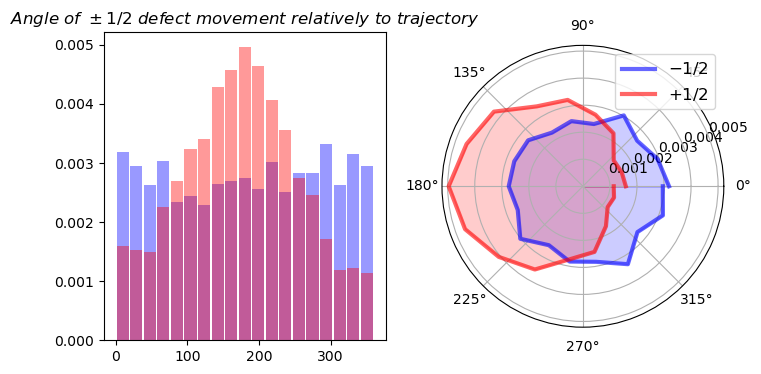

In [33]:
%matplotlib inline
bins_number = 19  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2.*np.pi, bins_number+1) #* 180/np.pi
bins_ = np.linspace(0, 2.*np.pi, bins_number)
width = 2 * np.pi / bins_number

df_p = all_pairs_df["angp1_rel_vel_angle"]#[~all_pairs_df.fusion]
df_m = all_pairs_df["angm1_rel_vel_angle"]#[~all_pairs_df.fusion]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p2,_,_ = ax1.hist(df_m*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
p1,_,_ = ax1.hist(df_p*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="r")

# ax2.bar(bins[:bins_number], p0, color="r", width=width, bottom=0., alpha=.4)
# ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0., alpha=.4,
#     label=r"%.1f $(\langle \theta \rangle _{tr} > \pi)$" % (circmean(df)*180/np.pi))

ax2.plot(bins_, p2, "b", linewidth=3, alpha=.6, label=r"$-1/2$")
ax2.fill_between(bins_, p2, color="b", alpha=.2)


ax2.plot(bins_, p1, "r", linewidth=3, alpha=.6, label=r"$+1/2$")
ax2.fill_between(bins_, p1, color="r", alpha=.2)



ax2.legend(fontsize=12)
ax1.set_title(r"$Angle ~of ~\pm 1/2 ~defect ~movement ~relatively ~to ~trajectory$")

In [26]:
circmean(df_p)*180/np.pi, circstd(df_p)*180/np.pi/df_p.shape[0]**.5

(174.3680965426868, 0.8197502645581188)

In [27]:
err

NameError: name 'err' is not defined

## Correlations

### Crosscorelation

In [34]:
def xcorr(image, pad=250):
    # methods = ["cv2.TM_CCOEFF_NORMED"] #'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
    #  'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

    method = "cv2.TM_CCORR_NORMED"
    image = image - image.mean()
    template = image[pad:-pad,pad:-pad]  
    xcorr = cv2.matchTemplate(image, template, eval(method))
    value = np.sqrt(((xcorr.shape[0]/2.)**2.) + ((xcorr.shape[1]/2.)**2.))
    polar_image = cv2.linearPolar(xcorr, (xcorr.shape[0]/2, xcorr.shape[1]/2), 
                                value, cv2.WARP_FILL_OUTLIERS)
    
    radial_corr = polar_image.mean(axis=0)
    return pd.DataFrame({
        "dist": np.arange(len(radial_corr)),
        "rcorr": radial_corr,
                         })

In [74]:
frame_num = 200
ori_lst = [analyze_defects(cv2.imread(im)[:,900:,0], sigma=11)[0] for im in image_list[:frame_num]]

(-0.1, 1.0)

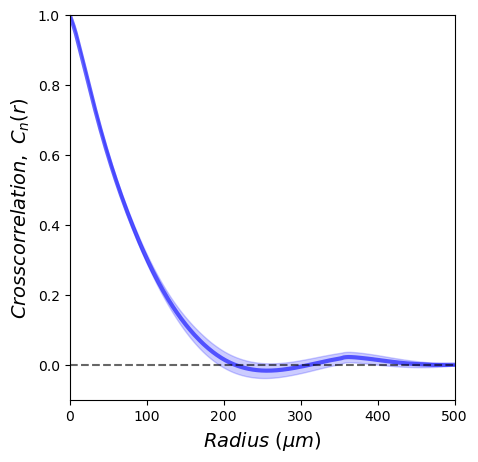

In [122]:
img = ori_lst[50]
funcs = [np.cos, np.sin]
colors  = ["r","g"]
pad = 250

rcorr = []
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
for img in ori_lst[::5]:
    for c,func in zip(colors,funcs):
        rcorr.append(xcorr(func(img), pad=pad))
        # ax1.plot(rcorr[-1].dist, rcorr[-1].rcorr, color=c, alpha=.2, linewidth=3)

df = pd.concat(rcorr)

plot_rolling_average(df, ax1, "rcorr", "dist", show=True, win=1, color="b", avfunc=np.mean, stdfunc=np.std)
plt.plot([0,2*pad],[0,0],"--k", alpha=.6)
plt.xlabel(r"$Radius ~(\mu m)$", fontsize=14)
plt.ylabel(r"$Crosscorrelation, ~C_n(r)$", fontsize=14)   
ax1.set_box_aspect(1); plt.xlim([0,2*pad]); plt.ylim([-.1,1])

In [129]:
def u_vel(im1,im2):
    return cv2.calcOpticalFlowFarneback(im1,im2, 
        None, 0.5, 3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

frame_num = 200
uv_vel_list = [u_vel(cv2.imread(img1)[:,900:,0],cv2.imread(img2)[:,900:,0]) for (img1,img2) in zip(image_list[:frame_num-1],image_list[1:frame_num])]

(-0.2, 1.0)

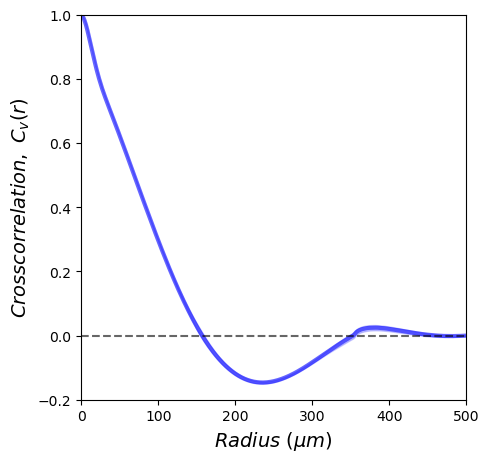

In [153]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
pad = 250
rcorr = []
for img in uv_vel_list[::1]:
    rcorr.append((xcorr(img[...,0], pad=pad) + xcorr(img[...,1], pad=pad))/2)

df = pd.concat(rcorr)

plot_rolling_average(df, ax1, "rcorr", "dist", show=True, win=1, color="b", avfunc=np.mean, stdfunc=np.std)
plt.plot([0,2*pad],[0,0],"--k", alpha=.6)
plt.xlabel(r"$Radius ~(\mu m)$", fontsize=14)
plt.ylabel(r"$Crosscorrelation, ~C_v(r)$", fontsize=14)   
ax1.set_box_aspect(1); plt.xlim([0,2*pad]); plt.ylim([-.2,1])    

In [98]:
def ori_vel(im1,im2):
    flow = cv2.calcOpticalFlowFarneback(im1,im2, 
        None, 0.5, 3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    return np.arctan2(flow[:,:,1],flow[:,:,0])

frame_num = 200
ori_vel_list = [ori_vel(cv2.imread(img1)[:,900:,0],cv2.imread(img2)[:,900:,0]) for (img1,img2) in zip(image_list[:frame_num-1],image_list[1:frame_num])]

(-0.2, 1.0)

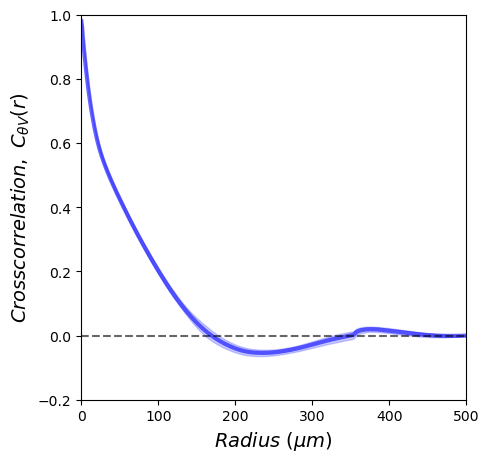

In [104]:
funcs = [np.cos, np.sin]
colors  = ["r","g"]
pad = 250

rcorr = []
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
for img in ori_vel_list[::5]:
    for c,func in zip(colors,funcs):
        rcorr.append(xcorr(img, pad=pad))
        # ax1.plot(rcorr[-1].dist, rcorr[-1].rcorr, color=c, alpha=.2, linewidth=3)

df = pd.concat(rcorr)

plot_rolling_average(df, ax1, "rcorr", "dist", show=True, win=1, color="b", avfunc=np.mean, stdfunc=np.std)
plt.plot([0,2*pad],[0,0],"--k", alpha=.6)
plt.xlabel(r"$Radius ~(\mu m)$", fontsize=14)
plt.ylabel(r"$Crosscorrelation, ~C_{\theta V}(r)$", fontsize=14)   
ax1.set_box_aspect(1); plt.xlim([0,2*pad]); plt.ylim([-.2,1])

### Time corelation

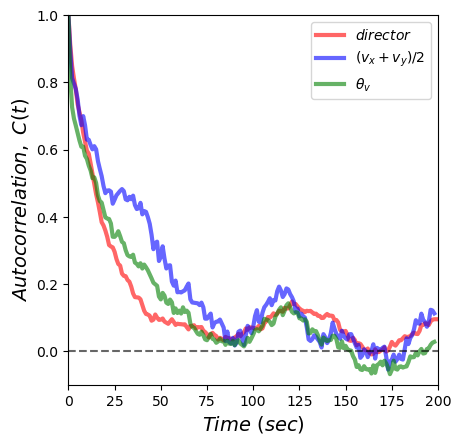

In [171]:
def timecorr(timeseries, func=None):
    def corr(timepoint, reference, func):
        if func:
            return np.mean(
                (func(timepoint)-func(timepoint).mean())*(func(reference)-func(reference).mean())
                )              
        else:
            return np.mean((timepoint-timepoint.mean())*(reference-reference.mean()))          

    norm = np.array(corr(timeseries[0], timeseries[0], func))
    return np.array([corr(t, timeseries[0], func) for t in timeseries]) / norm


ori_corr = (timecorr(ori_lst, np.cos) + timecorr(ori_lst, np.sin))/2
plt.plot(np.arange(len(ori_corr)), ori_corr,'-r', alpha=.6, linewidth=3, label=r"$director$")

u_vel_list = [uv[...,0] for uv in uv_vel_list]
v_vel_list = [uv[...,1] for uv in uv_vel_list]
vel_corr = (timecorr(u_vel_list) + timecorr(u_vel_list))/2
plt.plot(np.arange(len(vel_corr)), vel_corr,'-b', alpha=.6, linewidth=3, label=r"$(v_x+v_y)/2$")

ori_vel_corr = (timecorr(ori_vel_list, np.cos) + timecorr(ori_vel_list, np.sin))/2
plt.plot(np.arange(len(ori_vel_corr)), ori_vel_corr,'-g', alpha=.6, linewidth=3, label=r"$\theta_v$")
plt.plot([0, len(ori_corr)],[0,0],'--k', alpha=.6)

plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Autocorrelation, ~C(t)$", fontsize=14)       
plt.gca().set_box_aspect(1); plt.xlim([0,200]); plt.ylim([-.1,1])
plt.legend()

In [227]:
def timecorr_average(timeseries, func=None, step=5):

    def timecorr(timeseries, func=func):
        def corr(timepoint, reference, func):
            if func:
                return np.mean(
                    (func(timepoint)-func(timepoint).mean())*(func(reference)-func(reference).mean())
                    )              
            else:
                return np.mean((timepoint-timepoint.mean())*(reference-reference.mean()))          

        norm = np.array(corr(timeseries[0], timeseries[0], func))
        # return np.array([corr(t, timeseries[0], func) for t in timeseries]) / norm
        tcorr = [corr(t, timeseries[0], func) for t in timeseries] / norm
        return pd.DataFrame({
            "time": np.arange(len(tcorr)),
            "tcorr": tcorr
            })
    
    tcorr = []
    for i in np.arange(0,len(timeseries[:-50]),step):
        tcorr.append(timecorr(timeseries[i:]))
    return pd.concat(tcorr)

u_vel_list = [uv[...,0] for uv in uv_vel_list]
v_vel_list = [uv[...,1] for uv in uv_vel_list]

df_ori = .5*(timecorr_average(ori_lst, func=np.cos) + timecorr_average(ori_lst, func=np.sin))
df_vel = .5*(timecorr_average(u_vel_list) + timecorr_average(v_vel_list))
df_vel_ori = .5*(timecorr_average(ori_vel_list, func=np.cos) + timecorr_average(ori_vel_list, func=np.sin))
 

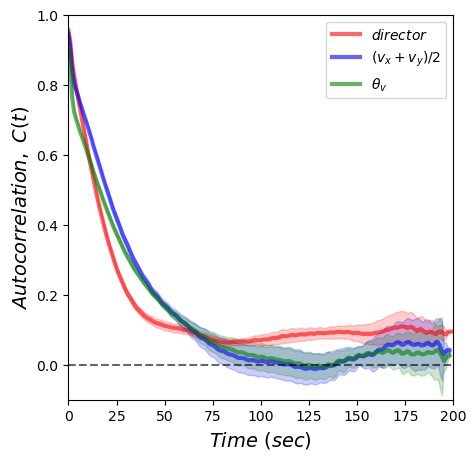

In [235]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

p = plot_rolling_average(df_ori, ax1, "tcorr", "time", win=1, color="r", avfunc=np.mean, stdfunc=np.std)
p = plot_rolling_average(df_vel, ax1, "tcorr", "time", win=1, color="b", avfunc=np.mean, stdfunc=np.std)
p = plot_rolling_average(df_vel_ori, ax1, "tcorr", "time", win=1, color="g", avfunc=np.mean, stdfunc=np.std)

plt.plot([0,0], [0,0],'-r', alpha=.6, linewidth=3, label=r"$director$")
plt.plot([0,0], [0,0],'-b', alpha=.6, linewidth=3, label=r"$(v_x+v_y)/2$")
plt.plot([0,0], [0,0], '-g', alpha=.6, linewidth=3, label=r"$\theta_v$")
plt.plot([0, len(ori_corr)],[0,0],'--k', alpha=.6)

plt.xlabel(r"$Time ~(sec)$", fontsize=14)
plt.ylabel(r"$Autocorrelation, ~C(t)$", fontsize=14)  
plt.gca().set_box_aspect(1); plt.xlim([0,200]); plt.ylim([-.1,1])
plt.legend()   

In [41]:
error_var_to_stop_execution

NameError: name 'error_var_to_stop_execution' is not defined

## Flow Averaging Around Defects

In [239]:
fuse_df = all_pairs_df[all_pairs_df["fusion"]]
fuse_df["angp1_rel"] = (fuse_df["angp1"] - fuse_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    fuse_df["angm"+str(i+1)+"_rel"] = (fuse_df["angm"+str(i+1)] - fuse_df["mp_angle"]) % (2*np.pi)

grouped = fuse_df.groupby('plus_id')["angp1_rel"]
fuse_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

create_df = all_pairs_df.loc[~all_pairs_df["fusion"]]
create_df["angp1_rel"] = (create_df["angp1"] - create_df["mp_angle"]) % (2*np.pi)

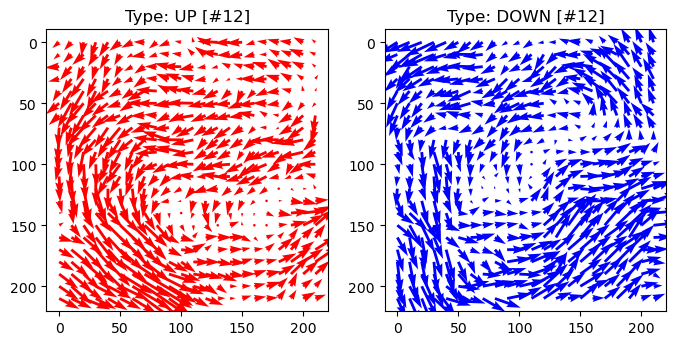

In [8]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

sys.path.append('../defect_functions') 
from defect_pairs import * 
from average_flows import * 

image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

frame = 51
img1 = cv2.imread(image_list[frame])[:,900:,0]
img2 = cv2.imread(image_list[frame+1])[:,900:,0] 
# df_frame = all_pairs_df[all_pairs_df.index == frame]
df_frame = all_pairs_df[all_pairs_df.index == frame]

u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="all")
u_dwn, v_dwn, up_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="minus")
y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
step = 10
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='r',
          width=.01, scale=10,)
ax1.set_title("Type: %1s [#%1d]" % ("UP", count_up))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='b',
          width=.01, scale=10,)
# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", count_up))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()


In [9]:
u_ups, v_ups, count_ups = [], [], []
u_dwns, v_dwns, count_dwns = [], [], []

all_frames = np.sort(all_pairs_df.index.unique().values)[1:200]

for frame in all_frames:
    img1 = cv2.imread(image_list[frame])[:,:,0] 
    img2 = cv2.imread(image_list[frame+1])[:,:,0]  
    df_frame = all_pairs_df[all_pairs_df.index == frame] #
    u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="all", filt=1)
    u_dwn, v_dwn, count_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="minus", filt=1)

    u_ups.append(u_up)
    v_ups.append(v_up)
    count_ups.append(count_up)

    u_dwns.append(u_dwn)
    v_dwns.append(v_dwn)
    count_dwns.append(count_dwn)
    
    progressBar(frame, len(all_frames))

#     if frame % 5:
#         save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         with open(save_path, 'wb') as f:
#                 pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
#                                 u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
#                                 ), f)  

#     progressBar(frame, len(all_frames))


# save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# with open(save_path, 'wb') as f:
#         pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
#                         u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
#                         ), f)  

u_ups = np.array(u_ups)
v_ups = np.array(v_ups)
count_ups = np.array(count_ups)

u_dwns = np.array(u_dwns)
v_dwns = np.array(v_dwns)
count_dwns = np.array(count_dwns)

# # remove zero counts
# u_ups = np.array(u_ups)
# v_ups = np.array(v_ups)
# count_ups = np.array(count_ups)

# u_dwns = np.array(u_dwns)
# v_dwns = np.array(v_dwns)
# count_dwns = np.array(count_dwns)


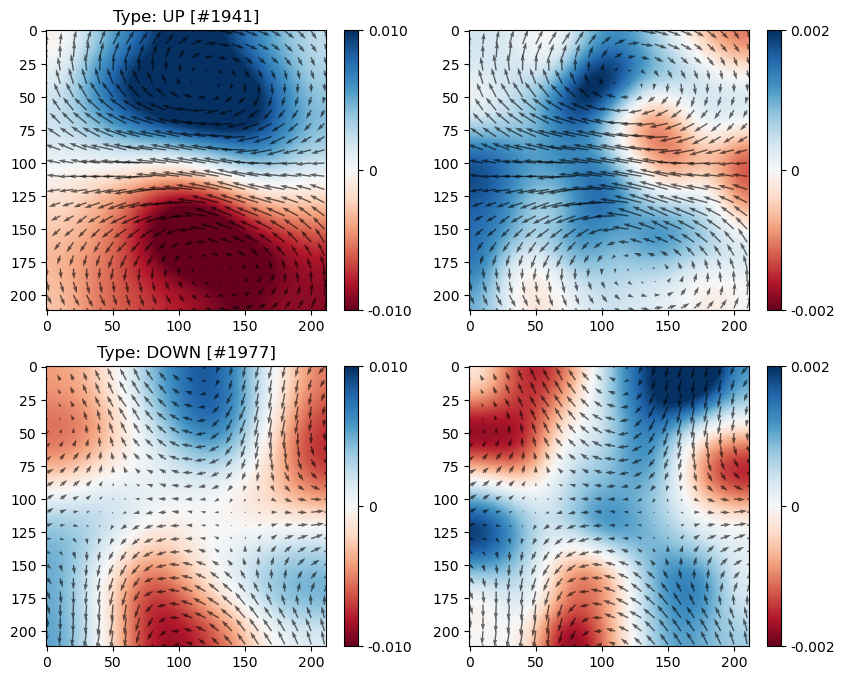

In [10]:
%matplotlib inline
filt = 20

u_up = np.average(u_ups[count_ups!= 0], axis=0, weights=count_ups[count_ups!= 0])
v_up = np.average(v_ups[count_ups!= 0], axis=0, weights=count_ups[count_ups!= 0])

u_dwn = np.average(u_dwns[count_dwns!= 0], axis=0, weights=count_dwns[count_dwns!= 0])
v_dwn = np.average(v_dwns[count_dwns!= 0], axis=0, weights=count_dwns[count_dwns!= 0])

y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, axs = plt.subplots(2,2, figsize=(10,8))
ax1,ax2,ax3,ax4 = axs.ravel()
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
step = 10

field = np.stack((u_up, v_up), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
c1 = ax1.imshow(vorticity, cmap='RdBu', vmin=-.01, vmax=.01)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
ax1.set_title("Type: %1s [#%1d]" % ("UP", np.sum(count_ups)))

divergence = gaussian_filter(divergence_npgrad(field), sigma=filt)
c2 = ax2.imshow(divergence, cmap='RdBu', vmin=-.002, vmax=.002)
ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)


field = np.stack((u_dwn, v_dwn), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
c3 = ax3.imshow(vorticity, cmap='RdBu', vmin=-.01, vmax=.01)
ax3.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
ax3.set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns)))
      

divergence = gaussian_filter(divergence_npgrad(field), sigma=filt)
c4 = ax4.imshow(divergence, cmap='RdBu', vmin=-.002, vmax=.002)
ax4.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
            

# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))

# Add colorbar, make sure to specify tick locations to match desired ticklabels
import matplotlib.ticker as mticker
ticks_vort, ticks_div = [-.01, 0, .01], [-.002, 0, .002]
for c,ticks in zip([c1,c2,c3,c4], [ticks_vort,ticks_div,ticks_vort,ticks_div]):
    fig.colorbar(c, ticks=ticks, format=mticker.FixedFormatter(("%.3f,%.0f,%.3f" % tuple(ticks)).split(',')))

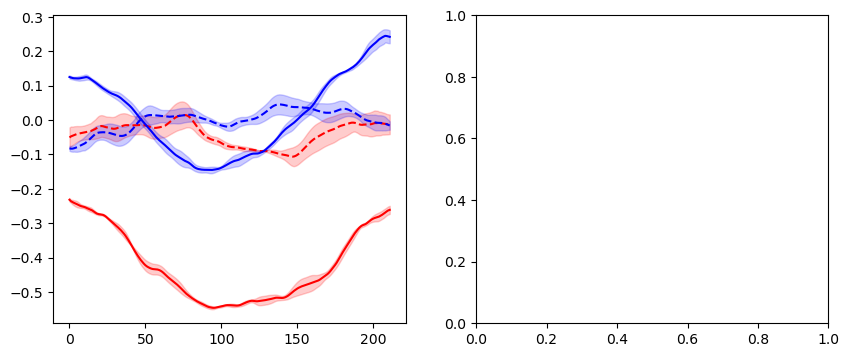

In [ ]:
c = u_up.shape[0]//2
dc = 10

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
av  = u_up[c-dc:c+dc,:].mean(axis=0)
std  = u_up[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "-r")
ax1.fill_between(xx, av-std, av+std,  color="r", alpha=.2)

av  = v_up[c-dc:c+dc,:].mean(axis=0)
std  = v_up[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "--r")
ax1.fill_between(xx, av-std, av+std,  color="r", alpha=.2)


av  = u_dwn[c-dc:c+dc,:].mean(axis=0)
std  = u_dwn[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "-b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)

av  = v_dwn[c-dc:c+dc,:].mean(axis=0)
std  = v_dwn[c-dc:c+dc,:].std(axis=0)
xx = np.arange(len(av))
ax1.plot(xx, av, "--b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)

# av  = u_up[:,c-dc:c+dc].mean(axis=1)
# std  = u_up[:,c-dc:c+dc].std(axis=1)
# xx = np.arange(len(av))
# ax1.plot(xx, av, "--g")
# ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)

# xx, av, std  = section(v_up[:,c-dc:c+dc], sec_axis="y")
# ax2.plot(xx, av, "--b")
# ax2.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
# ax1.set_title(r"$v_x$"); ax1.set_ylabel(r"$average ~holrisontal ~velocity$"); ax1.set_box_aspect(1)

# xx, av, std  = section(u_dwn[:,c-dc:c+dc], sec_axis="y")
# ax1.plot(xx, av, "--g")
# ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
# xx, av, std  = section(v_dwn[:,c-dc:c+dc], sec_axis="y")
# ax2.plot(xx, av, "--g")
# ax2.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
# ax2.set_title(r"$v_y$"); ax2.set_ylabel(r"$average ~vertical ~velocity$"); ax2.set_box_aspect(1)

In [ ]:
u_up.shape[0]//2

106

# ------------ TRIES --------------------

            params     sigma
mu1       0.901669  0.003664
sigma1    0.193545  0.003874
A1      147.740700  2.081777
mu2       1.604523  0.005555
sigma2    0.208389  0.005988
A2      100.580279  2.021162


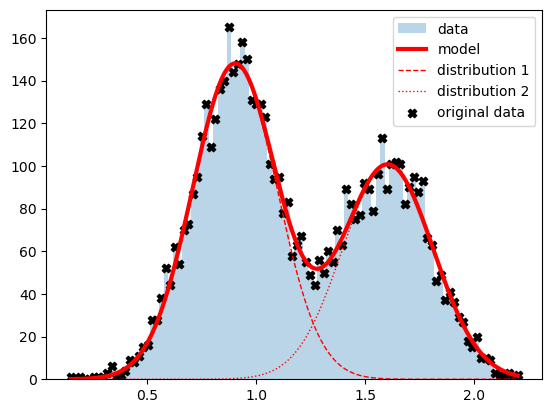

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data = np.concatenate((np.random.normal(.9, .2, 3500), np.random.normal(1.6, .2, 2500)))
y,x,_= plt.hist(data, 100, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)

expected = (.8, .2, 250, 1.8, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma = np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 

(0.9029628377210909, 0.0020159130483440495, 0.0005729815563985407)

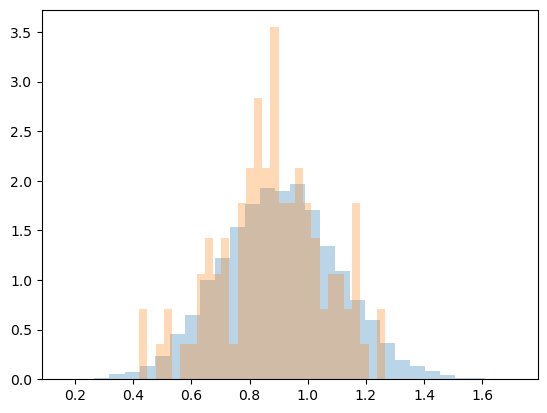

In [ ]:
# import numpy as np
# from scipy.stats import sem
a = np.random.normal(.9, .2, 10000)
plt.hist(a, 30, alpha=.3, density=True)
plt.hist(a[:100], 30, alpha=.3, density=True)
# plt.plot(np.arange(len(a)), a, alpha=.3)
a.mean(), sem(a), sem(a[:100])/1000**.5